<a href="https://colab.research.google.com/github/srirampai/Active_learning/blob/main/IMDB_Small_Text_V1_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install small-text[transformers]  # use "small-text" without "[transformers]" if you want to work on the CPU only
%pip install datasets
%pip install matplotlib

     |████████████████████████████████| 97 kB 2.9 MB/s 
     |████████████████████████████████| 15.7 MB 25.2 MB/s 
     |████████████████████████████████| 3.5 MB 38.8 MB/s 
     |████████████████████████████████| 6.8 MB 32.0 MB/s 
     |████████████████████████████████| 895 kB 39.8 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 44.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 re

     |████████████████████████████████| 311 kB 4.3 MB/s 
     |████████████████████████████████| 133 kB 41.2 MB/s 
     |████████████████████████████████| 243 kB 50.7 MB/s 
     |████████████████████████████████| 1.1 MB 45.5 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 44.8 MB/s 
     |████████████████████████████████| 271 kB 47.5 MB/s 


In [ ]:
import datasets
import logging
import numpy as np

In [ ]:
# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

raw_dataset = datasets.load_dataset('imdb')
num_classes = np.unique(raw_dataset['train']['label']).shape[0]



Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


In [ ]:
import transformers
from transformers import AutoTokenizer

In [ ]:
transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
from small_text.integrations.transformers.datasets import TransformersDataset


def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length=max_length,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))

    return TransformersDataset(data_out)


train = get_transformers_dataset(tokenizer, raw_dataset['train']['text'], raw_dataset['train']['label'])
test = get_transformers_dataset(tokenizer, raw_dataset['test']['text'], raw_dataset['test']['label'])

**Pool Based Active Learner**

In [ ]:
from small_text.active_learner import PoolBasedActiveLearner
from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import PredictionEntropy
from small_text.integrations.transformers import TransformerModelArguments

In [ ]:
# simulates an initial labeling to warm-start the active learning process, ChanGING THE SAMPLE SIZE TO 15
def initialize_active_learner(active_learner, y_train):
    x_indices_initial = random_initialization_balanced(y_train, n_samples=15)
    y_initial = y_train[x_indices_initial]

    active_learner.initialize_data(x_indices_initial, y_initial)

    return x_indices_initial

In [ ]:
transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'early_stopping_no_improvement': -1
                                                                }))
query_strategy = PredictionEntropy()
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
labeled_indices = initialize_active_learner(active_learner, train.y)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Active Learning Loop**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


num_queries = 15

#Evaulate Function 
def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)
    test_precision = precision_score(y_pred_test, test.y)
    test_recall = recall_score(y_pred_test, test.y)
    #confustion_matrix_dis = confusion_matrix(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    print('Train Precision: {:.2f}'.format(precision_score(y_pred, train.y)))
    print('Test Precision: {:.2f}'.format(test_precision))
    print('Train Recall: {:.2f}'.format(recall_score(y_pred, train.y)))
    print('Test Recall: {:.2f}'.format(test_recall))
    
    #print
    
    return test_acc, test_precision, test_recall


results = []
results.append(evaluate(active_learner, train[labeled_indices], test))

for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    q_indices = active_learner.query(num_samples=35)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[q_indices]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    labeled_indices = np.concatenate([q_indices, labeled_indices])

    print('Iteration #{:d} ({} samples)'.format(i, len(labeled_indices)))
    results.append(evaluate(active_learner, train[labeled_indices], test))

Train accuracy: 0.87
Test accuracy: 0.50
Train Precision: 0.71
Test Precision: 0.06
Train Recall: 1.00
Test Recall: 0.52


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #0 (50 samples)
Train accuracy: 0.76
Test accuracy: 0.50
Train Precision: 1.00
Test Precision: 0.97
Train Recall: 0.70
Test Recall: 0.50


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #1 (85 samples)
Train accuracy: 0.95
Test accuracy: 0.57
Train Precision: 0.90
Test Precision: 0.82
Train Recall: 1.00
Test Recall: 0.54


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #2 (120 samples)
Train accuracy: 0.63
Test accuracy: 0.51
Train Precision: 0.53
Test Precision: 0.21
Train Recall: 0.64
Test Recall: 0.53


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #3 (155 samples)
Train accuracy: 0.68
Test accuracy: 0.52
Train Precision: 0.37
Test Precision: 0.09
Train Recall: 0.87
Test Recall: 0.67


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #4 (190 samples)
Train accuracy: 0.97
Test accuracy: 0.66
Train Precision: 0.95
Test Precision: 0.49
Train Recall: 0.99
Test Recall: 0.74


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #5 (225 samples)
Train accuracy: 0.96
Test accuracy: 0.72
Train Precision: 0.95
Test Precision: 0.61
Train Recall: 0.97
Test Recall: 0.78


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #6 (260 samples)
Train accuracy: 0.81
Test accuracy: 0.61
Train Precision: 0.85
Test Precision: 0.60
Train Recall: 0.82
Test Recall: 0.61


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #7 (295 samples)
Train accuracy: 0.96
Test accuracy: 0.65
Train Precision: 0.94
Test Precision: 0.75
Train Recall: 0.98
Test Recall: 0.63


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #8 (330 samples)
Train accuracy: 0.96
Test accuracy: 0.76
Train Precision: 0.95
Test Precision: 0.77
Train Recall: 0.98
Test Recall: 0.75


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #9 (365 samples)
Train accuracy: 0.76
Test accuracy: 0.57
Train Precision: 0.78
Test Precision: 0.72
Train Recall: 0.78
Test Recall: 0.55


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #10 (400 samples)
Train accuracy: 0.55
Test accuracy: 0.50
Train Precision: 1.00
Test Precision: 0.98
Train Recall: 0.55
Test Recall: 0.50


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #11 (435 samples)
Train accuracy: 0.96
Test accuracy: 0.69
Train Precision: 0.95
Test Precision: 0.73
Train Recall: 0.97
Test Recall: 0.68


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #12 (470 samples)
Train accuracy: 0.96
Test accuracy: 0.69
Train Precision: 0.96
Test Precision: 0.60
Train Recall: 0.96
Test Recall: 0.73


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #13 (505 samples)
Train accuracy: 0.86
Test accuracy: 0.66
Train Precision: 0.91
Test Precision: 0.79
Train Recall: 0.83
Test Recall: 0.63


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration #14 (540 samples)
Train accuracy: 0.95
Test accuracy: 0.77
Train Precision: 0.95
Test Precision: 0.77
Train Recall: 0.94
Test Recall: 0.76


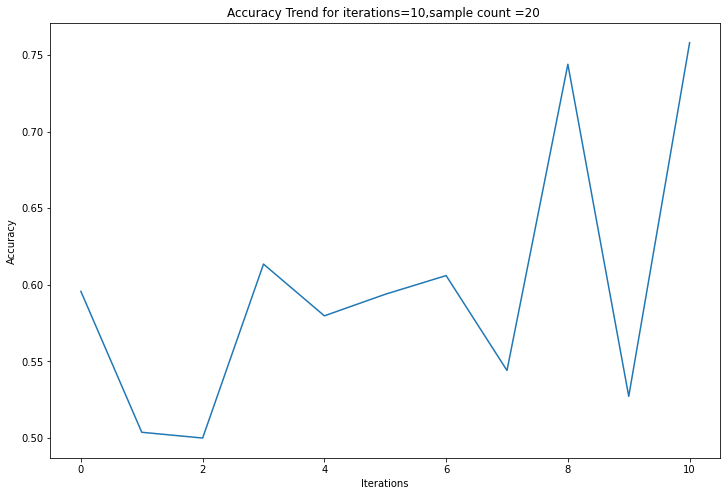

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.xlabel('Iterations') 
plt.ylabel('Accuracy') 
  
# displaying the title
plt.title("Accuracy Trend for Iterations=10,Sample count =20 ")

ax.plot(np.arange(num_queries+1), results)

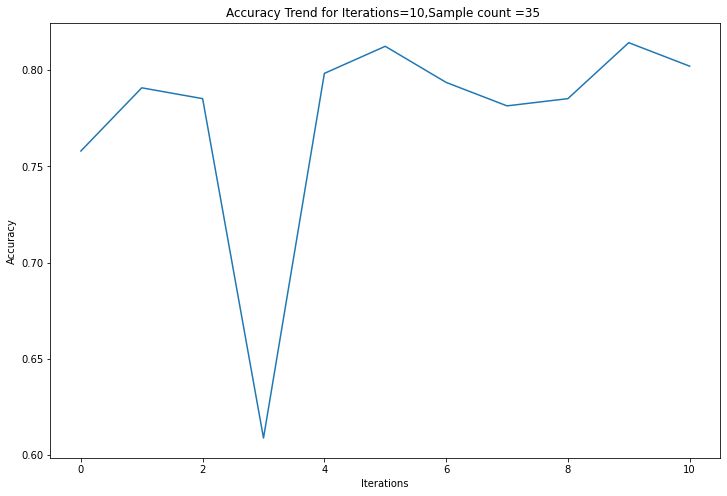

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.xlabel('Iterations') 
plt.ylabel('Accuracy') 
  
# displaying the title
plt.title("Accuracy Trend for Iterations=10,Sample count =35 ")

ax.plot(np.arange(num_queries+1), results)